<h1 style="color: blue; font-size: 24px;">Digit Multiclass Classification</h1>

# Installs & Imports

In [1]:
!pip install optuna -q

In [2]:
# Standard libraries
import math
import os
import random
import sys
import time

# Data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# Scikit-Learn
from sklearn import datasets
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.svm import SVC

# TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks, layers, models, regularizers

# Optuna
import optuna
import optuna.visualization as ov

# Loading the Data

For this multiclass classification task, we will be working with the digits dataset from scikit-learn. The dataset contains 8x8 pixel images of handwritten digits from 0 through 9. This means we will have 10 different classes in our classification task.

In [3]:
# Load the digits dataset
digits = datasets.load_digits()

# Exploring the Data

Let's examine some basic information about the dataset, including the dataset shape, image shape, number of samples, and class-related information. We can also look at the way the data is represented for the first few entries.

In [4]:
# Examine basic information
print(f"Dataset shape: {digits.data.shape}")
print(f"Image shape: {digits.images[0].shape}")
print(f"Number of samples: {len(digits.images)}")
print(f"Number of classes: {len(np.unique(digits.target))}")
print(f"Class labels: {np.unique(digits.target)}")

Dataset shape: (1797, 64)
Image shape: (8, 8)
Number of samples: 1797
Number of classes: 10
Class labels: [0 1 2 3 4 5 6 7 8 9]


In [5]:
# Examine first few entries
print(f"First few data points {digits.data[:5]}")
print(f"First few labels {digits.target[:5]}")

First few data points [[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
  15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
   0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
   0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]
 [ 0.  0.  0. 12. 13.  5.  0.  0.  0.  0.  0. 11. 16.  9.  0.  0.  0.  0.
   3. 15. 16.  6.  0.  0.  0.  7. 15. 16. 16.  2.  0.  0.  0.  0.  1. 16.
  16.  3.  0.  0.  0.  0.  1. 16. 16.  6.  0.  0.  0.  0.  1. 16. 16.  6.
   0.  0.  0.  0.  0. 11. 16. 10.  0.  0.]
 [ 0.  0.  0.  4. 15. 12.  0.  0.  0.  0.  3. 16. 15. 14.  0.  0.  0.  0.
   8. 13.  8. 16.  0.  0.  0.  0.  1.  6. 15. 11.  0.  0.  0.  1.  8. 13.
  15.  1.  0.  0.  0.  9. 16. 16.  5.  0.  0.  0.  0.  3. 13. 16. 16. 11.
   5.  0.  0.  0.  0.  3. 11. 16.  9.  0.]
 [ 0.  0.  7. 15. 13.  1.  0.  0.  0.  8. 13.  6. 15.  4.  0.  0.  0.  2.
   1. 13. 13.  0.  0.  0.  0.  0.  2. 15. 11.  1.  0.  0.  0.  0.  0.  1.
  12. 12.  1.  0.  0.  0.  0.  0.  

As we can see from the basic information and printed outputs, each image is represented as a 64-feature vector (8x8 pixels). Each feature indicates the gray scale intensity of a pixel. Let's plot some of the images next.

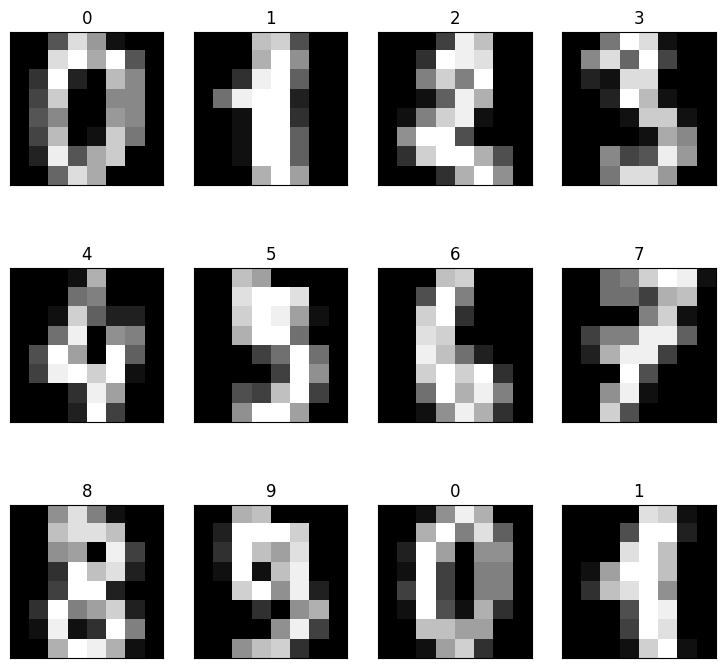

In [6]:
# Function to plot images
def plot_images(images, labels, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray, interpolation='nearest')
        plt.title(labels[i], size=12)
        plt.xticks(())
        plt.yticks(())
    plt.show()

# Plot first few images
plot_images(digits.data, digits.target, 8, 8)

The digit images appear quite blurry, primarily due to the low resolution and the downstream consequences that this has on the grayscale representation and interpolation. Let's improve the visibility of the digit images by resizing the images and utilizing bicubic interpolation to smoothen out their appearance.

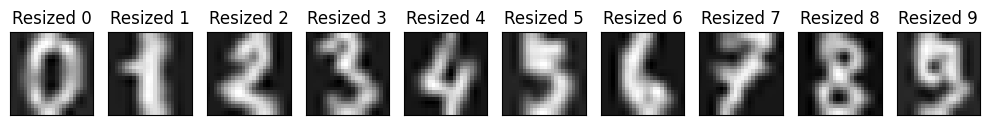

In [7]:
# Function to resize images using bicubic interpolation
def resize_image(image, scale_percent):
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    # resize image
    resized = cv2.resize(image, dim, interpolation=cv2.INTER_CUBIC)
    return resized

# Scale up the images by 300%
scale_percent = 300

# Apply the resize function to each digit
resized_digits = []
for i in range(len(digits.images)):
    digit = digits.images[i]
    resized_digit = resize_image(digit, scale_percent)
    resized_digits.append(resized_digit)

# Plot the resized images
plt.figure(figsize=(10, 20))
for i, digit in enumerate(resized_digits):
    if i < 10:
        plt.subplot(1, 10, i + 1)
        plt.imshow(digit, cmap=plt.cm.gray)
        plt.title(f'Resized {digits.target[i]}', size=12)
        plt.xticks([])
        plt.yticks([])
plt.tight_layout()
plt.show()

The digits are still not crystal clear, but they are much more visible than before! Let's see how the digits are distributed in the dataset.

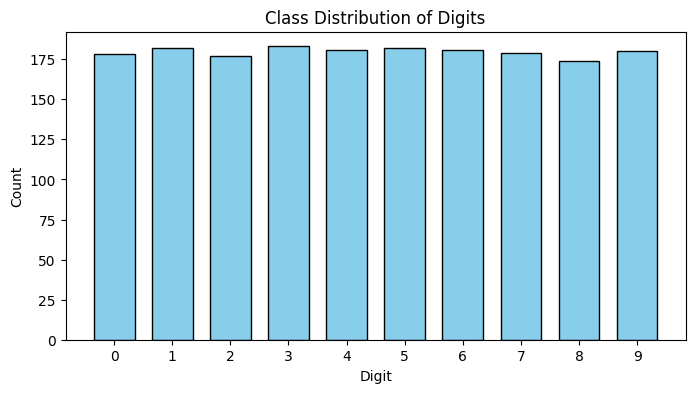

In [8]:
# Plot the class distribution
plt.figure(figsize=(8, 4))
plt.hist(digits.target, bins=10, range=[0, 10], align='left', rwidth=0.7,
         color='skyblue', edgecolor='black')
plt.title('Class Distribution of Digits')
plt.xlabel('Digit')
plt.ylabel('Count')
plt.xticks(np.arange(0, 10, step=1))
plt.show()

It looks like we have a fairly balanced dataset. There are approximately 175 instances of each digit in the dataset.

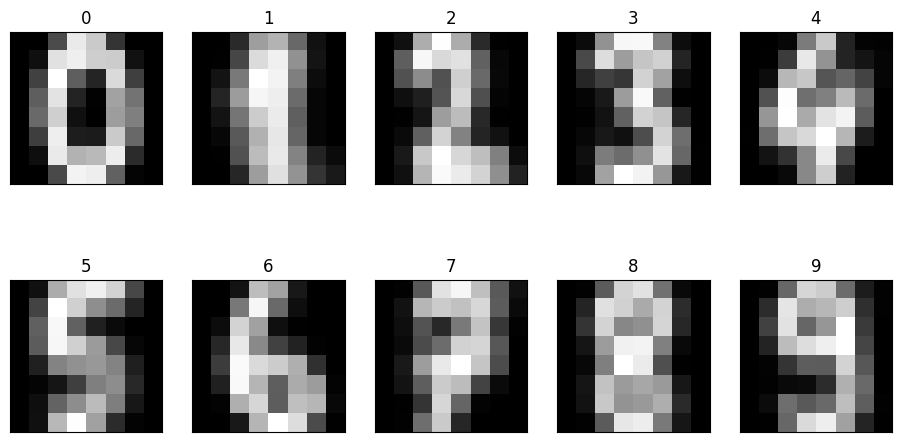

In [9]:
# Calculate the mean images for each digit
mean_images = []
for i in range(10):
    mean_images.append(np.mean(digits.data[digits.target == i], axis=0))

# Plot mean images
plot_images(np.array(mean_images), np.arange(10), 8, 8, n_row=2, n_col=5)

The averaged digits appear a bit more recognizable, even without resizing them and applying bicubic interpolation. Averaging the pixel values across many different examples has likely reduced the impact of some of the noisier individual variations.

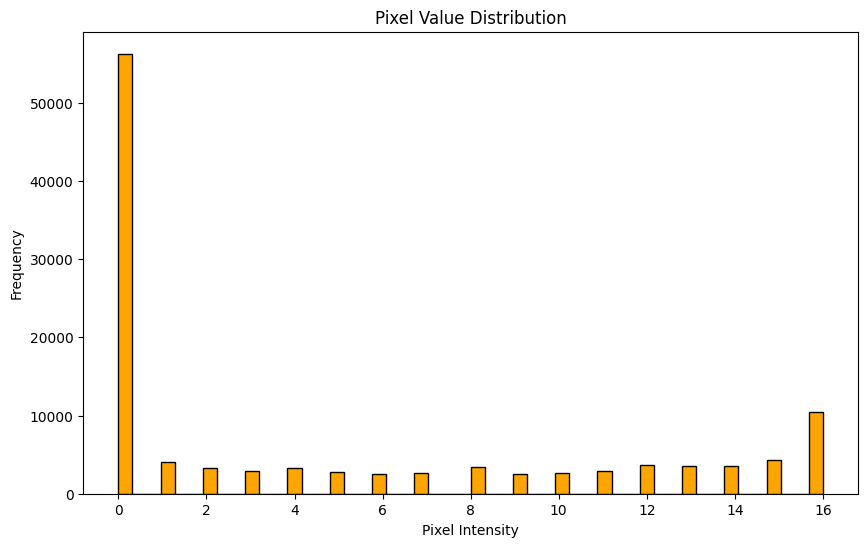

In [10]:
# Plot of pixel value distribution
plt.figure(figsize=(10, 6))
plt.hist(digits.data.flatten(), bins=50, color='orange', edgecolor='black')
plt.title('Pixel Value Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

Shown above is the distribution of pixel intensity for the dataset. The intensity values range from 0 to 16, where 0 represents black and 16 represents white. An overwhelming majority of the pixels across the images are black. This makes sense, since the image background, which occupies a large amount of the image space, is black. There does not appear to be many pixels represented in the intermediate grayscale values. This suggests that the images display relatively higher levels of contrast, with most parts of the images either being black or white.

# Preprocessing the Data

## Splitting the Data

Our first step for preprocessing the data will be to split the digits dataset into training and test partitions. Later in our workflow, we will be utilizing k-fold cross-validation for tuning our models. K-fold cross-validation randomly splits the training set into different folds and uses one of these folds for model evaluation. This process is repeated multiple times and the results of these iterations are averaged to provide a more robust estimation of model performance. Since we are using k-fold cross-validation in our workflow, we will forego creating a holdout validation partition when splitting the data.

In [11]:
# Define the variables
X = digits.data
y = digits.target

In [12]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

In [13]:
# Check the splits
print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (1437, 64)
Test set size: (360, 64)


## Normalizing the Data

Next, we will normalize the data so the pixel values are between 0 and 1. This will improve numerical stability with certain machine learning algorithms that are sensitive to the input scale or that use gradient optimization.

In [14]:
# Normalize the data to be between 0 and 1
X_train /= 16.0
X_test /= 16.0

In [15]:
# Check the shapes of the normalized data
print(f"Normalized training set size: {X_train.shape}")
print(f"Normalized test set size: {X_test.shape}")

Normalized training set size: (1437, 64)
Normalized test set size: (360, 64)


# Model Building & Tuning

The following section will involve building a variety of models to predict digit labels. The models we will be creating include: a K-Nearest Neighbors classifier, a Support Vector Machine classifier, a Gaussian Naive Bayes classifier, an Extremely Randomized Trees classifier, and a Convolutional Neural Network classifier.

We will not only be building the models, but tuning the model hyperparameters as well. The Optuna library will be used for the hyperparameter tuning process. This library utilizes a Bayesian optimization algorithm called Tree-structured Parzen Estimator (TPE). TPE models the probability distribution of the hyperparameters, given prior results, and then selects new values based on the estimated likelihood of performance improvement. With Optuna, the whole procedure is as easy as defining an objective function, running a study, and using the best hyperparameters to train a final, tuned model.

During hyperparameter tuning, we will be employing 5-fold cross-validation. Rather than tuning based on accuracy scores, we will be tuning based on F1 scores. These scores represent the harmonic mean between precision and recall, and can be a more informative metric for model performance in classification problems than simple accuracy.

## K-Nearest Neighbors

The first type of model that we will build and tune is a K-Nearest Neighbors classifier. The KNN algorithm examines the k-nearest training data points to the unseen example. Based on the labels of these nearest neighbors, the label for the new data point is determined. One way to do this is with a "majority vote" type of approach. The choice of the k parameter can greatly affect the results. A k-value that is too small can make the algorithm sensitive to noise, while a k-value that is too large can lead to overly generalized results.

In [16]:
# Define the objective function
def objective_knn(trial):
    # Hyperparameters to tune
    n_neighbors = trial.suggest_int('n_neighbors', 1, 30)
    p = trial.suggest_int('p', 1, 2)

    # Create the KNN model
    model = KNeighborsClassifier(n_neighbors=n_neighbors, p=p)

    # Perform cross-validation and calculate the average F1 score
    f1_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro')
    average_f1 = np.mean(f1_scores)

    return average_f1

In [17]:
# Run the hyperparameter optimization
study_knn = optuna.create_study(direction='maximize', pruner=optuna.pruners.SuccessiveHalvingPruner())
study_knn.optimize(objective_knn, n_trials=100)

# Best hyperparameters, trial, and score
print(f"Best hyperparameters: {study_knn.best_params}")
print(f"Best trial: {study_knn.best_trial.params}")
print(f"Best score: {study_knn.best_value}")

[I 2024-01-14 05:19:59,293] A new study created in memory with name: no-name-e6652ba1-7a83-4941-a55b-3bb88412931a
[I 2024-01-14 05:19:59,474] Trial 0 finished with value: 0.9533382672103045 and parameters: {'n_neighbors': 25, 'p': 1}. Best is trial 0 with value: 0.9533382672103045.
[I 2024-01-14 05:19:59,586] Trial 1 finished with value: 0.9838462993648418 and parameters: {'n_neighbors': 6, 'p': 2}. Best is trial 1 with value: 0.9838462993648418.
[I 2024-01-14 05:19:59,708] Trial 2 finished with value: 0.9902022472153975 and parameters: {'n_neighbors': 1, 'p': 2}. Best is trial 2 with value: 0.9902022472153975.
[I 2024-01-14 05:19:59,863] Trial 3 finished with value: 0.9747902061955556 and parameters: {'n_neighbors': 15, 'p': 2}. Best is trial 2 with value: 0.9902022472153975.
[I 2024-01-14 05:19:59,987] Trial 4 finished with value: 0.9788743780169045 and parameters: {'n_neighbors': 8, 'p': 2}. Best is trial 2 with value: 0.9902022472153975.
[I 2024-01-14 05:20:00,284] Trial 5 finished

Best hyperparameters: {'n_neighbors': 1, 'p': 2}
Best trial: {'n_neighbors': 1, 'p': 2}
Best score: 0.9902022472153975


According to the tuning results, the best number of nearest neighbors is 1 and the best power parameter is 2, which is equivalent to using the Euclidean distance. Let's view some Optuna visualizations. These are rendered with Plotly, so they may not show up unless viewing in a Colab environment.

In [18]:
# Function to plot tuning results
def plot_optuna_results(study):
    """
    Function to plot various Optuna visualizations for a given study.

    :param study: Optuna study object.
    """
    # Optimization history
    fig = ov.plot_optimization_history(study)
    fig.show()

    # Parameter importances
    fig = ov.plot_param_importances(study)
    fig.show()

    # Slice plot
    fig = ov.plot_slice(study)
    fig.show()

    # Contour plot
    fig = ov.plot_contour(study)
    fig.show()

    # Parallel coordinate plot
    fig = ov.plot_parallel_coordinate(study)
    fig.show()

# Call the function
plot_optuna_results(study_knn)

The visualizations show that the best combination of hyperparameters was found quite early on, and the number of nearest neighbors was a more significant contributor with respect to model performance than the power parameter. The slice plot suggests there is a nearly linear, inverse relationship between the model performance and the number of nearest neighbors. As the number of neighbors increases, the model performance appears to decrease in tandem. Next, let's train the final model and evaluate its performance metrics.

In [19]:
# Train the final model
best_params_knn = study_knn.best_params
final_model_knn = KNeighborsClassifier(**best_params_knn)
final_model_knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [20]:
# Function to calculate metrics
def calculate_metrics(model, X_test, y_test, num_classes=10):
    # Predict on test set
    y_test_pred = model.predict(X_test)

    # Get probability predictions for ROC-AUC
    if hasattr(model, "predict_proba"):
        y_test_proba = model.predict_proba(X_test)
        y_test_bin = label_binarize(y_test, classes=range(num_classes))
        roc_auc = roc_auc_score(y_test_bin, y_test_proba, multi_class='ovo', average='macro')
    else:
        # If model does not have predict_proba, use decision function
        # For models that do not have either, ROC-AUC is not applicable
        if hasattr(model, "decision_function"):
            y_test_scores = model.decision_function(X_test)
            y_test_bin = label_binarize(y_test, classes=range(num_classes))
            roc_auc = roc_auc_score(y_test_bin, y_test_scores, multi_class='ovo', average='macro')
        else:
            roc_auc = float('nan')

    # Calculate other metrics
    metrics = {
        'Accuracy': accuracy_score(y_test, y_test_pred),
        'Precision': precision_score(y_test, y_test_pred, average='macro', zero_division=0),
        'Recall': recall_score(y_test, y_test_pred, average='macro', zero_division=0),
        'F1 Score': f1_score(y_test, y_test_pred, average='macro', zero_division=0),
        'ROC-AUC': roc_auc
    }

    # Create a DataFrame
    metrics_df = pd.DataFrame(metrics, index=['Score'])
    return metrics_df.T

In [21]:
# Function to plot metrics
def plot_metrics(metrics_df):
    metrics_df.plot(kind='bar', figsize=(10, 6), legend=False)
    plt.title('Model Evaluation Metrics')
    plt.ylabel('Score')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0.8, 1.0)
    plt.show()

In [22]:
# KNN Model DataFrame
metrics_knn = calculate_metrics(final_model_knn, X_test, y_test, num_classes=10)
metrics_knn

,Score
Accuracy,0.986111
Precision,0.986575
Recall,0.985873
F1 Score,0.985891
ROC-AUC,0.992165


Excluding ROC-AUC, the metrics are all between 98 to 99%. We have obtained some strong results with a relatively simple model.

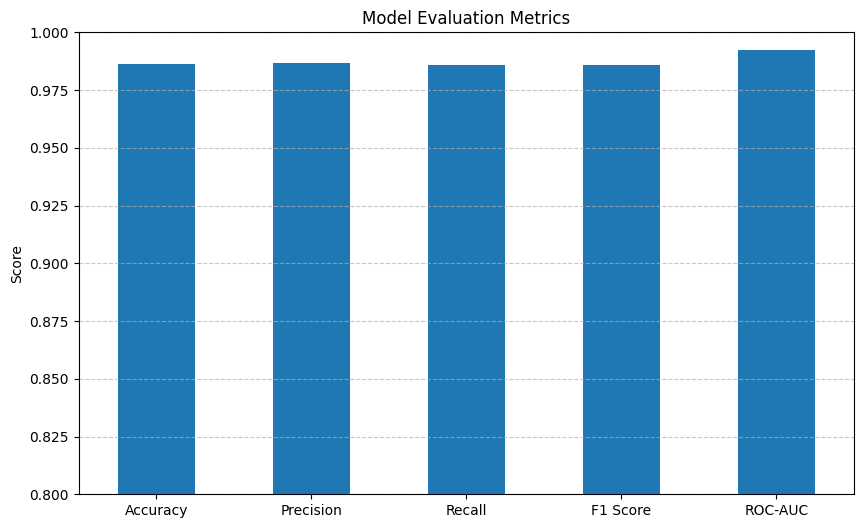

In [23]:
# KNN Model Plot
plot_metrics(metrics_knn)

## Support Vector Machine

The second model we will create and tune is a Support Vector Machine classifier. This model attempts to locate the best boundary (hyperplane) that separates the various classes in a higher-dimensional feature space. For datasets that are nonlinearly separable, SVMs can use the kernel trick to obtain the transformed values without engaging in computationally expensive calculations.

In [24]:
# Define the objective function
def objective_svc(trial):
    # Hyperparameters to tune
    C = trial.suggest_float('C', 1e-10, 1e10, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])

    # Additional hyperparameters for 'poly' kernel
    if kernel == 'poly':
        degree = trial.suggest_int('degree', 1, 5)

    # Create the SVC model
    if kernel == 'poly':
        model = SVC(C=C, kernel=kernel, gamma=gamma, degree=degree, probability=True)
    else:
        model = SVC(C=C, kernel=kernel, gamma=gamma, probability=True)

    # Perform cross-validation and calculate the average F1 score
    f1_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro')
    average_f1 = np.mean(f1_scores)

    return average_f1

In [25]:
# Run the hyperparameter optimization
study_svc = optuna.create_study(direction='maximize', pruner=optuna.pruners.SuccessiveHalvingPruner())
study_svc.optimize(objective_svc, n_trials=100)

# Best hyperparameters, trial, and score
print(f"Best hyperparameters: {study_svc.best_params}")
print(f"Best trial: {study_svc.best_trial.params}")
print(f"Best score: {study_svc.best_value}")

[I 2024-01-14 05:20:27,681] A new study created in memory with name: no-name-13b56443-a3eb-4d44-b587-7165f992e2e7
[I 2024-01-14 05:20:31,672] Trial 0 finished with value: 0.0468764482864613 and parameters: {'C': 7.791330218071806e-10, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 0 with value: 0.0468764482864613.
[I 2024-01-14 05:20:32,765] Trial 1 finished with value: 0.9887990981598589 and parameters: {'C': 3673.636974536217, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 1 with value: 0.9887990981598589.
[I 2024-01-14 05:20:33,686] Trial 2 finished with value: 0.9716753172494945 and parameters: {'C': 2974.8604788937696, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 1 with value: 0.9887990981598589.
[I 2024-01-14 05:20:34,553] Trial 3 finished with value: 0.9716753172494945 and parameters: {'C': 133434622.56448327, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 1 with value: 0.9887990981598589.
[I 2024-01-14 05:20:36,855] Trial 4 finished with value: 0.04610078810

Best hyperparameters: {'C': 2.349369401264667, 'kernel': 'rbf', 'gamma': 'scale'}
Best trial: {'C': 2.349369401264667, 'kernel': 'rbf', 'gamma': 'scale'}
Best score: 0.9901561602731335


C and gamma are important hyperparameters for the Support Vector Machine model. C is a regularization parameter that moderates the trade-off between correct classification and margin maximization. A low value leads to a larger margin and simpler decision boundary at the expense of classification accuracy. A high value leads to a smaller margin and a more complex, and possibly overfitting, model. The gamma parameter indicates how far the influence of a single training example can reach. A larger gamma can lead to a more complex model, and potentially overfitting, model. A scaled gamma indicates a balanced approach that is adapted to the dataset and considers the number of features. The Radial Basis Function Kernel was selected as the best kernel type. This allows the model to find a nonlinear classification boundary in the transformed feature space.

In [26]:
# Plot tuning results
plot_optuna_results(study_svc)

The visualizations show that the model reached peak levels of performance even more quickly than the KNN classifier. Moreover, the results were more consistent across trials than with KNN. The type of kernel was the most relevant hyperparameter with respect to model performance, followed by the gamma specifications.

In [27]:
# Train the final model
best_params_svc = study_svc.best_params
final_model_svc = SVC(**best_params_svc, probability=True)
final_model_svc.fit(X_train, y_train)

SVC(C=2.349369401264667, probability=True)

In [28]:
# SVC Model DataFrame
metrics_svc = calculate_metrics(final_model_svc, X_test, y_test, num_classes=10)
metrics_svc

,Score
Accuracy,0.991667
Precision,0.992034
Recall,0.991508
F1 Score,0.991578
ROC-AUC,0.999948


The model achieved scores of 99+% on all metrics. This is an improvement relative to the KNN classifier, without needing to utilize significantly more computational complexity.

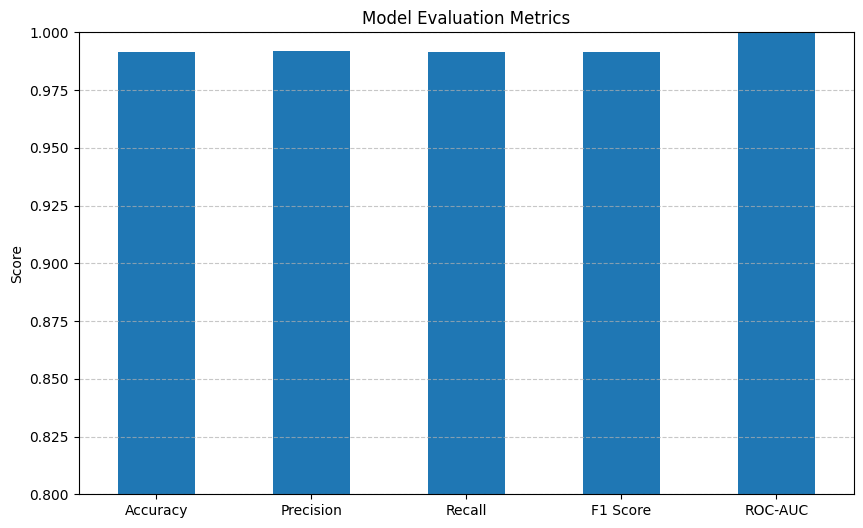

In [29]:
# SVC Model Plot
plot_metrics(metrics_svc)

## Gaussian Naive Bayes

Next, we will build and tune the Gaussian Naive Bayes model. In a GNB model, a couple of key assumptions are held to be true. First, it is assumed that the probability of the features follows a normal distribution. Second, it is assumed that the there is an independent relationship between every pair of features, given the class label. These assumptions are often violated, but the GNB model can still yield promising results. In essence, the classifier calculates the mean and variance of the pixel intensities for each class and applies the Gaussian probability density function to compute the likelihood of observing a particular pixel intensity, given a class. For multiclass problems, the posterior probability for each class is computed and then the predicted class is the one with the highest posterior probability.

In [30]:
# Define the objective function
def objective_gnb(trial):
    # Hyperparameters to tune
    var_smoothing = trial.suggest_float('var_smoothing', 1e-10, 1e-1, log=True)

    # Create the GaussianNB model
    model = GaussianNB(var_smoothing=var_smoothing)

    # Perform cross-validation and calculate the average F1 score
    f1_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro')
    average_f1 = np.mean(f1_scores)

    return average_f1

In [31]:
# Run the hyperparameter optimization
study_gnb = optuna.create_study(direction='maximize', pruner=optuna.pruners.SuccessiveHalvingPruner())
study_gnb.optimize(objective_gnb, n_trials=100)

# Best hyperparameters, trial, and score
print(f"Best hyperparameters: {study_gnb.best_params}")
print(f"Best trial: {study_gnb.best_trial.params}")
print(f"Best score: {study_gnb.best_value}")

[I 2024-01-14 05:22:48,384] A new study created in memory with name: no-name-8c892b23-8079-41c0-a33c-8504d312fb8b
[I 2024-01-14 05:22:48,415] Trial 0 finished with value: 0.8084378190775405 and parameters: {'var_smoothing': 1.0079803388839009e-10}. Best is trial 0 with value: 0.8084378190775405.
[I 2024-01-14 05:22:48,441] Trial 1 finished with value: 0.9226448785567578 and parameters: {'var_smoothing': 0.010700741780133274}. Best is trial 1 with value: 0.9226448785567578.
[I 2024-01-14 05:22:48,469] Trial 2 finished with value: 0.9173861226883624 and parameters: {'var_smoothing': 0.0029037380117907315}. Best is trial 1 with value: 0.9226448785567578.
[I 2024-01-14 05:22:48,494] Trial 3 finished with value: 0.8999026096754257 and parameters: {'var_smoothing': 0.000142221580804622}. Best is trial 1 with value: 0.9226448785567578.
[I 2024-01-14 05:22:48,520] Trial 4 finished with value: 0.8439819335923318 and parameters: {'var_smoothing': 5.628416630636651e-09}. Best is trial 1 with valu

Best hyperparameters: {'var_smoothing': 0.04387458516941709}
Best trial: {'var_smoothing': 0.04387458516941709}
Best score: 0.9272442760394135


Extremely small variances can cause the model to overfit to the training data. The variance smoothing parameter adds a portion of the largest variance of all features to the variances calculated for each feature. This help to widen the distribution and reduce the impact of features with small variances.

In [32]:
# Plot tuning results
plot_optuna_results(study_gnb)

The model quickly reaches high levels of performance as quickly as the KNN and SVM classifiers. Although, the performance across trials is not as consistent as with SVM. Additionally, there appears to be a positive, nearly linear relationship between the variance smoothing parameter and the model performance scores.

In [33]:
# Train the final model
best_params_gnb = study_gnb.best_params
final_model_gnb = GaussianNB(**best_params_gnb)
final_model_gnb.fit(X_train, y_train)

GaussianNB(var_smoothing=0.04387458516941709)

In [34]:
# GNB Model DataFrame
metrics_gnb = calculate_metrics(final_model_gnb, X_test, y_test, num_classes=10)
metrics_gnb

,Score
Accuracy,0.930556
Precision,0.931456
Recall,0.930296
F1 Score,0.929836
ROC-AUC,0.994292


The Gaussian Naive Bayes model performs well on this task, given that the strong assumptions it makes about image data are bound to be violated. The score for most metrics is approximately 93%. This is not as performant as the KNN classifier or the SVM classifier, but it is decent given the limitations of the GNB model.

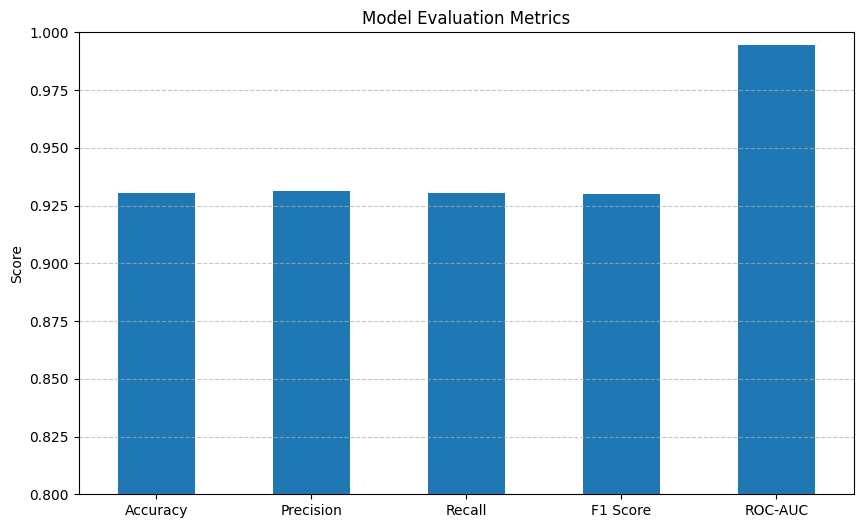

In [35]:
# GNB Model Plot
plot_metrics(metrics_gnb)

## Extremely Randomized Trees

A more complex machine learning model that we will be examining is the Extremely Randomized Trees classifier. This is an ensemble learning algorithm provided by scikit-learn. To understand this type of model, we need to understand how decision trees and the random forest algorithm works.

In decision tree models, the feature space is recursively partitioned into regions. Decisions are made to split the data based on a particular feature value threshold, with the aim of maximizing the resulting partition homogeneity. Decision trees, especially deeper ones, can be prone to overfitting.

To mitigate this issue, ensemble methods like the random forest algorithm have been employed. Ensemble approaches combine multiple trees to obtain more robust results. Each tree in a random forest model is built using a different bootstrap sample from the original data, and a random subset of features is considered for partitioning at each node. This can lead to more tree variation and greater generalizability.

The ERT classifier takes this whole concept a step further by adding even more randomness. It does this by selecting cut-point thresholds randomly at each node. This extra stochasticity can often yield greater performance compared to a typical random forest model.

In [36]:
# Define the objective function
def objective_ert(trial):
    # Hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 1, 100, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)

    # Create the ERT model
    model = ExtraTreesClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    # Perform cross-validation and calculate the average F1 score
    f1_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro')
    average_f1 = np.mean(f1_scores)

    return average_f1

In [37]:
# Run the hyperparameter optimization
study_ert = optuna.create_study(direction='maximize', pruner=optuna.pruners.SuccessiveHalvingPruner())
study_ert.optimize(objective_ert, n_trials=100)

# Best hyperparameters, trial, and score
print(f"Best hyperparameters: {study_ert.best_params}")
print(f"Best trial: {study_ert.best_trial.params}")
print(f"Best score: {study_ert.best_value}")

[I 2024-01-14 05:22:52,144] A new study created in memory with name: no-name-bb860189-3050-43e0-a61e-940304d1d12c
[I 2024-01-14 05:22:58,081] Trial 0 finished with value: 0.929964618683053 and parameters: {'n_estimators': 828, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.929964618683053.
[I 2024-01-14 05:23:03,421] Trial 1 finished with value: 0.8693529987228297 and parameters: {'n_estimators': 841, 'max_depth': 2, 'min_samples_split': 10, 'min_samples_leaf': 19}. Best is trial 0 with value: 0.929964618683053.
[I 2024-01-14 05:23:06,919] Trial 2 finished with value: 0.8027038227027772 and parameters: {'n_estimators': 583, 'max_depth': 1, 'min_samples_split': 11, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.929964618683053.
[I 2024-01-14 05:23:15,412] Trial 3 finished with value: 0.961026297629832 and parameters: {'n_estimators': 1000, 'max_depth': 63, 'min_samples_split': 5, 'min_samples_leaf': 11}. Best is trial 3 with value: 

Best hyperparameters: {'n_estimators': 501, 'max_depth': 89, 'min_samples_split': 3, 'min_samples_leaf': 1}
Best trial: {'n_estimators': 501, 'max_depth': 89, 'min_samples_split': 3, 'min_samples_leaf': 1}
Best score: 0.9811475231514597


In [38]:
# Plot tuning results
plot_optuna_results(study_ert)

The visualizations show that the ERT model achieves a high level of performance after a small number of trials. It does not appear to be as efficient as the SVM classifier, however. The maximum depth was the most important hyperparameter with respect to model performance. Tree depth can often be a significant determinant of whether a model overfits, so this result is understandable.

In [39]:
# Train the final model
best_params_ert = study_ert.best_params
final_model_ert = ExtraTreesClassifier(**best_params_ert)
final_model_ert.fit(X_train, y_train)

ExtraTreesClassifier(max_depth=89, min_samples_split=3, n_estimators=501)

In [40]:
# ERT Model DataFrame
metrics_ert = calculate_metrics(final_model_ert, X_test, y_test, num_classes=10)
metrics_ert

,Score
Accuracy,0.980556
Precision,0.981038
Recall,0.980317
F1 Score,0.980414
ROC-AUC,0.999620


The metrics, excluding ROC-AUC, are all slightly above 98%. These results are satisfactory, but they do not outdo the simple KNN and SVM classifiers. Moreover, the added complexity and time required to run the same tuning procedure are perhaps not worth the sub-optimal level of performance we obtained relative to the simpler, more performant models.

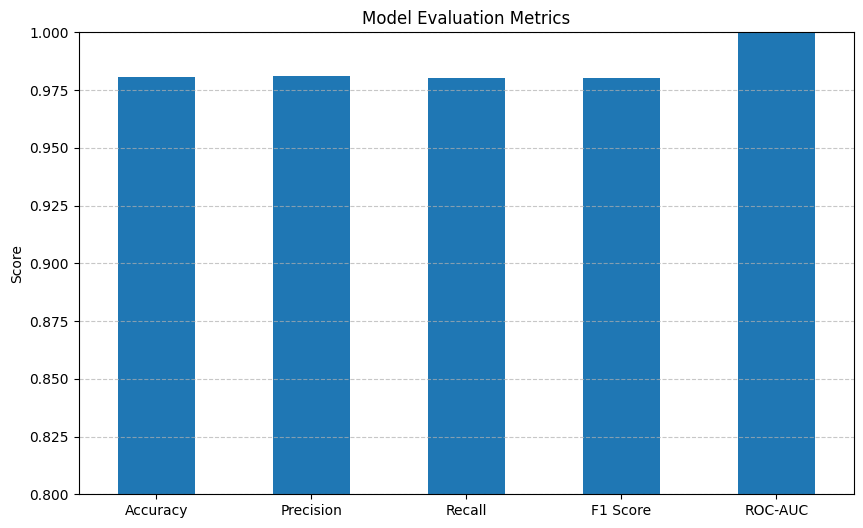

In [41]:
# ERT Model Plot
plot_metrics(metrics_ert)

## Convolutional Neural Network

The last type of model we will build and tune is a Convolutional Neural Network classifier. In a CNN model, the filters of the Convolutional Layers move across the image, perform matrix multiplication operations, and create a feature map. In this way, the CNN detects or "learns" the features of the images. Features can be simple at first, such as edges and textures, and can then become more complex in subsequent layers. After the convolution phase, an activation function is applied which allows the model to learn the complex nonlinearity of the data. Pooling Layers can be applied to reduce the size of the feature maps, thereby easing the computational burden. The CNN is completed with a Fully Connected Layer to classify the image.

Advanced techniques such as residual connections can be used to deal with the problem of vanishing gradients. This is an issue where the model stops learning or is learning too slowly. Residual connections allow the activation from one layer to skip directly to another later layer, preventing the model from getting stuck and allowing for deeper model architectures. Dropout entails randomly de-activating certain neurons in the CNN. This means that they do not participate in forward and backward propagation, thereby preventing the model from becoming overly dependent on certain neurons during the learning process. Batch normalization involves normalizing the outputs of the layers, which stabilizes and speeds up the training process.

For this task, we will incorporate the scikeras library, which allows us to create Keras models and wrap them to be compatible with the scikit-learn API.

In [42]:
!pip install scikeras -q

The image data needs to be reshaped to be compatible with the way the Keras CNN model expects it.

In [43]:
# Reshape the data to (n_samples, 8, 8, 1)
X_train_reshaped = X_train.reshape(-1, 8, 8, 1)
X_test_reshaped = X_test.reshape(-1, 8, 8, 1)

In [44]:
from scikeras.wrappers import KerasClassifier

# Define the CNN model
def create_cnn(n_conv_layers, n_dense_layers, n_filters, kernel_size, dropout_rate, l2_reg):
    # Create the input layer
    inputs = layers.Input(shape=(8, 8, 1))
    x = inputs

    # Convolutional layers with residual connections
    for i in range(n_conv_layers):
        x_shortcut = x
        x = layers.Conv2D(n_filters, kernel_size, activation='relu', padding='same',
                          kernel_regularizer=regularizers.l2(l2_reg))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout_rate)(x)
        if i % 2 == 1:  # Add a residual connection every two layers
            x = layers.Add()([x, x_shortcut])

    x = layers.Flatten()(x)

    # Dense layers
    for _ in range(n_dense_layers):
        x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
        x = layers.Dropout(dropout_rate)(x)

    outputs = layers.Dense(10, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [45]:
# Define the objective function
def objective_cnn(trial):
    n_conv_layers = trial.suggest_int('n_conv_layers', 2, 5)
    n_dense_layers = trial.suggest_int('n_dense_layers', 1, 3)
    n_filters = trial.suggest_categorical('n_filters', [16, 32, 64])
    kernel_size = trial.suggest_categorical('kernel_size', [3, 5])
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
    l2_reg = trial.suggest_float('l2_reg', 1e-5, 1e-2, log=True)

    # Create the CNN model
    model = KerasClassifier(build_fn=lambda: create_cnn(
        n_conv_layers=n_conv_layers,
        n_dense_layers=n_dense_layers,
        n_filters=n_filters,
        kernel_size=kernel_size,
        dropout_rate=dropout_rate,
        l2_reg=l2_reg
    ), epochs=30, verbose=0)

    # Create ReduceLROnPlateau callback
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, min_lr=1e-10, verbose=0)

    # Set fit_params as a dictionary
    fit_params = {'callbacks': [reduce_lr]}

    # Perform cross-validation and calculate the average F1 score
    f1_scores = cross_val_score(model, X_train_reshaped, y_train, cv=5, scoring='f1_macro', fit_params=fit_params, n_jobs=-1)
    average_f1 = np.mean(f1_scores)

    return average_f1

In [46]:
# Run the hyperparameter optimization
study_cnn = optuna.create_study(direction='maximize', pruner=optuna.pruners.SuccessiveHalvingPruner())
study_cnn.optimize(objective_cnn, n_trials=100)

# Best hyperparameters, trial, and score
print(f"Best hyperparameters: {study_cnn.best_params}")
print(f"Best trial: {study_cnn.best_trial.params}")
print(f"Best score: {study_cnn.best_value}")

[I 2024-01-14 05:29:18,327] A new study created in memory with name: no-name-7e11c3ff-36c5-4656-bcd1-4d3e92cf6739
[I 2024-01-14 05:29:36,797] Trial 0 finished with value: 0.9773756126210238 and parameters: {'n_conv_layers': 2, 'n_dense_layers': 1, 'n_filters': 32, 'kernel_size': 5, 'dropout_rate': 0.33357630276474026, 'l2_reg': 0.0037450762107007983}. Best is trial 0 with value: 0.9773756126210238.
[I 2024-01-14 05:30:00,963] Trial 1 finished with value: 0.9852533666122041 and parameters: {'n_conv_layers': 5, 'n_dense_layers': 2, 'n_filters': 32, 'kernel_size': 3, 'dropout_rate': 0.4149136770680203, 'l2_reg': 2.285976862255478e-05}. Best is trial 1 with value: 0.9852533666122041.
[I 2024-01-14 05:30:13,054] Trial 2 finished with value: 0.9811409483143547 and parameters: {'n_conv_layers': 3, 'n_dense_layers': 2, 'n_filters': 16, 'kernel_size': 5, 'dropout_rate': 0.2498972058679645, 'l2_reg': 0.0004714935809620435}. Best is trial 1 with value: 0.9852533666122041.
[I 2024-01-14 05:30:27,2

Best hyperparameters: {'n_conv_layers': 3, 'n_dense_layers': 1, 'n_filters': 64, 'kernel_size': 3, 'dropout_rate': 0.3394884460165398, 'l2_reg': 0.0024038879856161256}
Best trial: {'n_conv_layers': 3, 'n_dense_layers': 1, 'n_filters': 64, 'kernel_size': 3, 'dropout_rate': 0.3394884460165398, 'l2_reg': 0.0024038879856161256}
Best score: 0.9923205264374705


There are a large number of hyperparameters that can be tuned for neural networks, as shown above.

In [47]:
# Plot tuning results
plot_optuna_results(study_cnn)

The visualizations show that the CNN model reached a performance peak less quickly than the other models. The dropout rate was the most influential hyperparameter for the tuning process.

In [48]:
# Create the ReduceLROnPlateau callback
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, min_lr=1e-10, verbose=1)

# Create a ModelCheckpoint callback to save the best model
model_checkpoint = callbacks.ModelCheckpoint(
    'best_model_cnn.tf',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Retrieve the best parameters
best_params_cnn = study_cnn.best_params

# Function to create the final CNN model using the best parameters
def create_final_cnn():
    return create_cnn(**best_params_cnn)

# Initialize KerasClassifier with the function to create the model
final_model_cnn = KerasClassifier(model=create_final_cnn, epochs=50, verbose=1)

# Train the final model
final_model_cnn.fit(X_train_reshaped, y_train, callbacks=[reduce_lr])

Epoch 1/50
45/45 [==============================] - 4s 9ms/step - loss: 1.6625 - accuracy: 0.6701
Epoch 2/50
45/45 [==============================] - 0s 5ms/step - loss: 0.9605 - accuracy: 0.8859
Epoch 3/50
45/45 [==============================] - 0s 5ms/step - loss: 0.8402 - accuracy: 0.9221
Epoch 4/50
45/45 [==============================] - 0s 5ms/step - loss: 0.7999 - accuracy: 0.9422
Epoch 5/50
45/45 [==============================] - 0s 5ms/step - loss: 0.7181 - accuracy: 0.9562
Epoch 6/50
45/45 [==============================] - 0s 5ms/step - loss: 0.6817 - accuracy: 0.9631
Epoch 7/50
45/45 [==============================] - 0s 5ms/step - loss: 0.6634 - accuracy: 0.9603
Epoch 8/50
45/45 [==============================] - 0s 5ms/step - loss: 0.6329 - accuracy: 0.9694
Epoch 9/50
45/45 [==============================] - 0s 5ms/step - loss: 0.5853 - accuracy: 0.9756
Epoch 10/50
45/45 [==============================] - 0s 5ms/step - loss: 0.5744 - accuracy: 0.9763
Epoch 11/50
45/45 [

KerasClassifier(
	model=<function create_final_cnn at 0x7bac57ec93f0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=50
	class_weight=None
)

In [49]:
# CNN Model DataFrame
metrics_cnn = calculate_metrics(final_model_cnn, X_test_reshaped, y_test, num_classes=10)
metrics_cnn

12/12 [==============================] - 0s 2ms/step


,Score
Accuracy,0.986111
Precision,0.987297
Recall,0.985794
F1 Score,0.985898
ROC-AUC,0.999965


The CNN model achieved between 98% and 99% on all metrics (and almost 100% for ROC-AUC). This performance is quite strong, which is perhaps to be expected of such a powerful model, especially with all the advanced model architecture elements we incorporated. However, we should question whether this level of performance is worth the additional computational and temporal resources, given that we can achieve comparable or even greater outcomes with the simple KNN and SVM Classifiers.

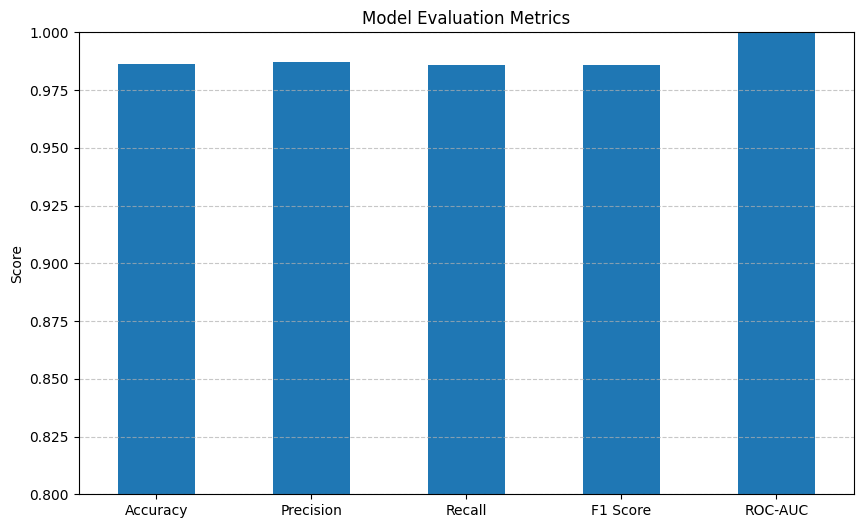

In [50]:
# CNN Model Plot
plot_metrics(metrics_cnn)

# Model Evaluation & Selection

Now that we have tuned the models and examined their performances individually, let's look at the performance results side-by-side to compare more easily and select the best model.

In [51]:
# Extract and rename the 'Score' column for each DataFrame
knn_scores = metrics_knn['Score'].rename('KNN')
svc_scores = metrics_svc['Score'].rename('SVC')
gnb_scores = metrics_gnb['Score'].rename('GNB')
cnn_scores = metrics_cnn['Score'].rename('CNN')

# Concatenate the score columns into a new DataFrame
metrics_comparison = pd.concat([knn_scores, svc_scores, gnb_scores, cnn_scores], axis=1)

# Display the comparison DataFrame
metrics_comparison

,KNN,SVC,GNB,CNN
Accuracy,0.986111,0.991667,0.930556,0.986111
Precision,0.986575,0.992034,0.931456,0.987297
Recall,0.985873,0.991508,0.930296,0.985794
F1 Score,0.985891,0.991578,0.929836,0.985898
ROC-AUC,0.992165,0.999948,0.994292,0.999965


In [52]:
# Function to bold the highest score in each metric
def bold_max_scores(series):
    """
    Apply bold font weight to the maximum value in a Series.
    """
    is_max = series == series.max()
    return ['font-weight: bold' if cell else '' for cell in is_max]

# Function to highlight the highest F1 Score in light blue
def highlight_max_f1(series):
    """
    Highlight the maximum F1 Score in light blue.
    """
    if series.name == 'F1 Score':
        is_max = series == series.max()
        return ['background-color: skyblue' if cell else '' for cell in is_max]
    return [''] * len(series)

# Apply the styling
styled_comparison = metrics_comparison.style.apply(bold_max_scores, axis=1) \
                                            .apply(highlight_max_f1, axis=1)

# Display the styled DataFrame
styled_comparison

,KNN,SVC,GNB,CNN
Accuracy,0.986111,0.991667,0.930556,0.986111
Precision,0.986575,0.992034,0.931456,0.987297
Recall,0.985873,0.991508,0.930296,0.985794
F1 Score,0.985891,0.991578,0.929836,0.985898
ROC-AUC,0.992165,0.999948,0.994292,0.999965


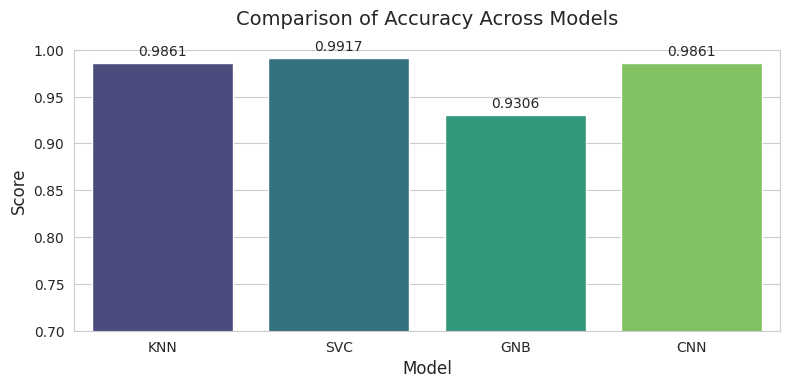

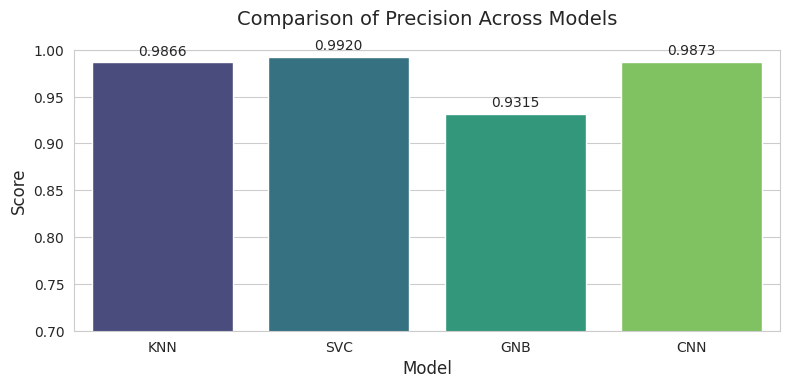

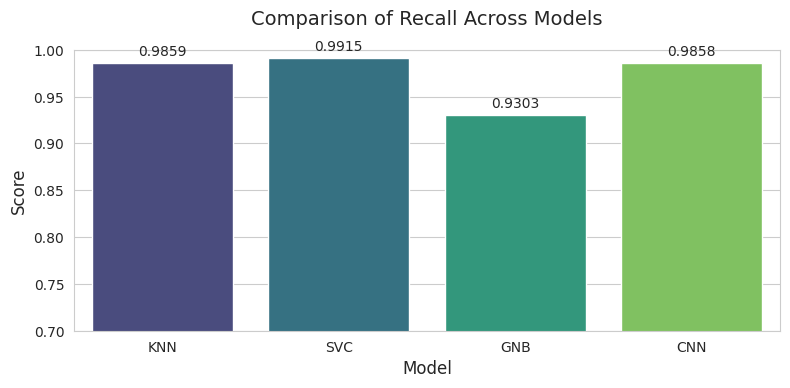

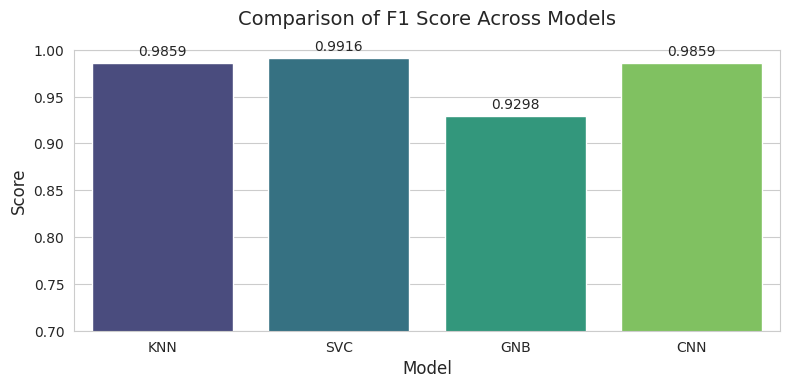

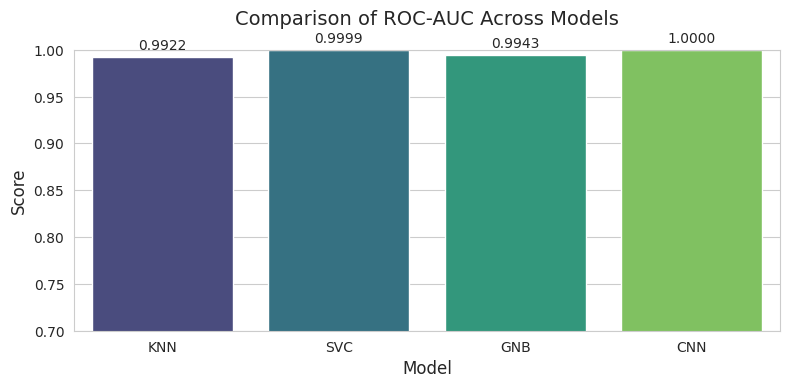

In [53]:
# Set the style of the plots
sns.set_style("whitegrid")

# Transpose the DataFrame for easier plotting
metrics_transposed = metrics_comparison.T

# Plotting each metric in a loop
for metric in metrics_transposed.columns:
    plt.figure(figsize=(8, 4))
    ax = sns.barplot(x=metrics_transposed.index, y=metrics_transposed[metric], palette="viridis")
    ax.set_title(f'Comparison of {metric} Across Models', fontsize=14, y=1.06)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylim(0.7, 1)
    ax.set_yticks(np.linspace(0.7, 1, 7))

    # Add data labels on each bar
    for container in ax.containers:
        ax.bar_label(container, fmt='%.4f', label_type='edge', padding=3, fontsize=10)

    # Show the plot
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

As shown in the results above, the SVM classifier performed the best on all metrics (excluding ROC-AUC), including the F1 score that we had decided to prioritize. It is also a relatively simple and computationally inexpensive model to implement, especially compared to the CNN model. Perhaps if the dataset was larger, the CNN model would have more utility. However, as it stands, the SVM classifier appears to be the best model. Therefore, we will utilize the SVM model in the subsequent inferencing phase.

# Prediction Examples

Before inferencing with new data, let's take a look at 5 random prediction examples drawn from the test dataset.

In [54]:
# Select 5 random examples from the test set
np.random.seed(42)  # Seed for reproducibility
random_indices = np.random.choice(len(X_test), 5, replace=False)
X_random_samples = X_test[random_indices]
y_random_samples = y_test[random_indices]

# Use the model to predict on these random test samples
predictions = final_model_svc.predict(X_random_samples)
predictions_proba = final_model_svc.predict_proba(X_random_samples)

In [68]:
# Create a DataFrame to display the results
results_df = pd.DataFrame({
    'Sample Index': random_indices,
    'Actual Label': y_random_samples,
    'Predicted Label': predictions,
    'Prediction Probability': [list(prob) for prob in predictions_proba]
})

In [69]:
# Format the probabilities for better readability
results_df['Prediction Probability'] = results_df['Prediction Probability'].apply(
    lambda probs: ["{:.2f}%".format(prob * 100) for prob in probs])

# Styling the DataFrame
styled_df = results_df.style.set_properties(**{'text-align': 'left'}).set_table_styles(
    [dict(selector='th', props=[('text-align', 'left')])]
).hide_index()

# View the DataFrame
styled_df

<ipython-input-69-f51cc669b868>:8: FutureWarning:

this method is deprecated in favour of `Styler.hide(axis="index")`



Sample Index,Actual Label,Predicted Label,Prediction Probability
224,4,4,"['0.07%', '0.04%', '0.05%', '0.04%', '98.90%', '0.14%', '0.28%', '0.31%', '0.14%', '0.04%']"
42,9,9,"['0.26%', '0.80%', '0.62%', '1.05%', '0.20%', '0.21%', '0.22%', '0.39%', '0.28%', '95.96%']"
285,9,9,"['0.17%', '0.04%', '0.07%', '0.12%', '0.11%', '0.14%', '0.09%', '0.10%', '0.16%', '99.00%']"
302,1,1,"['0.38%', '82.08%', '2.60%', '4.61%', '0.47%', '0.51%', '0.22%', '1.53%', '3.07%', '4.53%']"
56,4,4,"['0.43%', '0.15%', '0.10%', '0.10%', '96.67%', '0.19%', '1.88%', '0.18%', '0.20%', '0.10%']"


The label predictions for the 5 random examples were correct. The prediction probabilities for the 10 different classes are listed in the above DataFrame as well.

# Inferencing New Data

For this inferencing section, we created a digit image with Krita, a free drawing application. We attempted to make it appear as close as possible to the original data, with a black background and the digit centrally located.

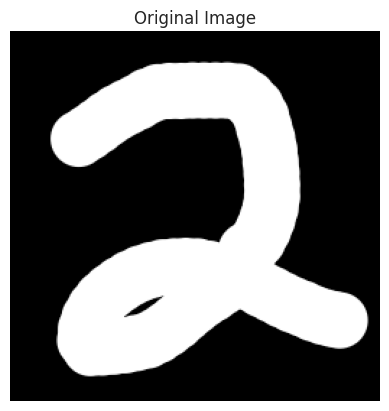

In [57]:
from PIL import Image

# Path to the image (made in Krita)
image_path = 'digit_2.png'

# Open the original image
img = Image.open(image_path)

# Display the original image
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Original Image')
plt.show()

The image is still quite different from the original dataset images, so we will attempt to process it in a way that will make it more similar to the original dataset images. If we do not do this, the model may not properly classify the digit.

In [58]:
# Function to preprocess the image
def preprocess_image(image_path):
    # Open the image
    img = Image.open(image_path).convert('L')

    # Resize to 8x8 pixels
    img_resized = img.resize((8, 8), Image.LANCZOS)

    # Convert to numpy array
    img_data = np.array(img_resized)

    # Normalize pixel values to be between 0 and 1
    max_value = img_data.max()
    if max_value > 0:  # Avoid division by zero
        img_data = img_data / max_value

    # Flatten the image
    img_data = img_data.reshape(1, -1)

    return img_data

In [59]:
# Preprocess the image
preprocessed_image = preprocess_image(image_path)

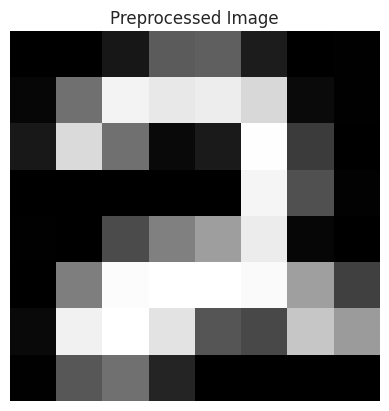

In [60]:
# Reshape to (8, 8) for viewing
plt.imshow(preprocessed_image.reshape(8, 8), cmap='gray')
plt.axis('off')
plt.title("Preprocessed Image")
plt.show()

Our new image looks more like the original dataset images as a result of our preprocessing operations.

In [61]:
# Predict using the model
predicted_class = final_model_svc.predict(preprocessed_image)
print(f"Predicted class: {predicted_class[0]}")

Predicted class: 7


In spite of our diligent efforts, the model failed to correctly predict the digit class. It predicted that the digit was a 7 rather than a 2. These two digits do have similar appearance features such as a middle-wise slant from bottom-left to top-right and a leftward protrusion at the top. At least the model did not predict an 8! Ultimately though, the model failed to label the new image data correctly. Given how well the model performed on the test data, the issue is likely with the way our new data instance was created and preprocessed. It is not sufficiently similar to the original dataset images, which is negatively impacting our inferencing demonstration.